# Python implementation of RICE-2010 - Inequalities run

This code tests the effect of various changes in the damage function (that all increase inequality). It uses a loop to optimize the model once for each type of modification. All results are then stored in panda dataframes.\
For a more general presentation of the model itself, see comments of the baseline run.

### 1. Package importation and parameters initialization

#### Package importation

In [1]:
import numpy as np
import time
import math
from numba import njit,guvectorize,float64
import scipy.optimize as opt 
from matplotlib import pyplot as plt

import datetime
import pandas as pd
import sys

%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Model parameters setting

In [40]:
# Time and regions settings

t = np.arange(1, 101) # number of periods
NT = len(t)
tstep = math.floor(500/NT) # number of years per period (set to cover total time span of 500 years)
c = np.arange(0, 12) # number of regions/countries
NC = len(c)
COUNTRIES = np.array(["US", "OECD Europe", "Japan", "Russia", "Eurasia", "China", "India", "Middle East",
                     "Sub-Sahara Africa", "Latin America", "Other high income", "Other developping"])

# Preferences

alpha = 1.5 # social welfare function parameter
rho = 0.015 # rate of social time preference (per YEAR)
rr = 1/((1+rho)**(tstep*(t-1))) # discount factor
weights = np.full(NC,1) # can be used to weight countries in the welfare function

#### Initial values of parameters

In [3]:
# Population

pop0W = 6410 # initial population, in millions
pop0 = np.array([296.84, 490.08, 127.77, 143.15, 155.94, 1304.50, 1094.58, 412.77, 763.51, 555.38, 129.17, 937.20])
l = np.zeros(shape = (NT, NC)) # labor force, equal to population
l[0] = pop0
gpop = 0.134 # growth rate of population
popasymW = 8699 # asymptotic population, in millions
popasym = np.array([477.76, 520.79, 93.41, 104.86, 136.79, 1297.67, 1399.41, 835.22, 1573.27, 684.95, 150.17, 1425.17]) 

# Production technology

gama = 0.300 # capital elasticity in production function
dk = 0.100 # depreciation rate of capital (per YEAR)
q0W = 55.37 # initial gross output, in trillion $
q0 = np.array([12.3979002, 13.03105748, 3.870283785, 1.697956695, 0.807335054, 5.333232743,
               2.440831513, 3.480103349, 1.300530136, 4.558476252, 3.84204975, 2.619188737])
k0W = 180 # initial capital value, in trillion $
k0 = np.array([22.85109974, 23.30227532, 7.133485459, 2.787107432, 1.362472206, 9.260935035,
               4.119188282, 5.416068489, 2.134752445, 7.692961135, 6.87039415, 4.420186931])
a0W = 5.115 # initial level of total factor productivity
a0 = np.array([11.34769536, 8.347821548, 9.062435157, 4.867730775, 2.70196943, 2.2708227,
               1.498373969, 3.894860836, 1.25125954, 3.730597775, 9.029344259, 1.754904331])
al = np.zeros(shape = (NT, NC)) # total factor productivity
al[0] = a0
gtfp0 = 0.0488 # initial growth rate of TFP (per PERIOD)
deltatfp = 0.005 # decline rate of TFP (per YEAR)
gtfp = gtfp0 * np.exp(-deltatfp*tstep*(t-1))

# Emissions

e0W = 7.91 # industrial emissions, GtC (per YEAR)
e0 = np.array([1.662133455, 1.146050619, 0.369965926, 0.431236182, 0.256666293, 1.600741128,
               0.40515159, 0.58967496, 0.191377084, 0.412272399, 0.541778261, 0.363952103]) * 3.666
miu0W = 0.2 # initial abatement/control rate
miu0 = np.full(NC,miu0W)
limmiu  = 1.0 # upper limit on abatement/control rate after 2150 (can be set to 1.2)
sig0W = e0W/(q0W*(1-miu0W)) # initial carbon intensity of output, in kgCO2/$
sig0 = e0/(q0*(1-miu0))
sigma = np.zeros(shape=(NT,NC)) # carbon intensity
sigma[0] = sig0
gsigma0 = -0.0125 # initial growth of sigma (per PERIOD)
deltasig = -0.009577 # decline rate of decarbonization (per YEAR)
gsig = np.zeros(NT) # growth of sigma
gsig[0] = gsigma0
etree0 = 1.6 * 3.666 # initial carbon emissions from land use, in GtC (per PERIOD)
deltatree = 0.01839 # decline rate of land use emissions (per YEAR)
etree = etree0*(1-deltatree)**(tstep*(t-1))
cumetree = np.zeros(NT) # cumulative emissions from land use
cumetree[0] = 100

# Carbon cycle

# initial conditions
mat0 = 829 # initial carbon concentration in the atmosphere, in GtC
mu0 = 460 # in upper oceans
ml0 = 1740 # in deep oceans
mateq = 588 # equilibrium carbon concentration in the atmosphere, in GtC
muoeq = 360 # in upper oceans
mdoeq = 1720 # in deep oceans
# flow paramaters (phi coefficients)
b12 = 0.12
b23 = 0.007
b11 = 1 - b12
b21 = b12*mateq/muoeq
b22 = 1 - b21 - b23
b32 = b23*muoeq/mdoeq
b33 = 1 - b32

# Climate model

teq = 3.2 # equilibrium temperature impact of CO2 doubling, in °C
feq = 3.8 # equilibrium forcing impact of CO2 doubling
fex0 = 0.5 # initial forcings of non-CO2 greenhouse gases, in Wm-2
fex1 = 1.0 # 2100 forcings
forcoth = np.full(NT,fex0) # exogenous radiative forcing
tocean0 = 0.0068 # initial temperature of deep oceans, in °C
tatm0 = 0.83 # initial atmospheric temperature, in °C
# temperature equation coefficients
c1 = 0.1005
c2 = feq/teq
c3 = 0.088
c4 = 0.025

# Damages

a1 = np.array([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0785, 0.4385, 0.2780, 0.3410, 0.0609, 0.0000, 0.1755])
# damage intercept coefficient
a2 = np.array([0.1414, 0.1591, 0.1617, 0.1151, 0.1305, 0.1259, 0.1689, 0.1586, 0.1983, 0.1345, 0.1564, 0.1734])
# damage second term coefficient
a3 = np.array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
# damage second term exponent

# Abatement cost

cost1 = np.zeros(shape=(NT,NC))
expcost2 = 2.8 # exponent of abatement cost function
pback = 1260 # initial cost of backstop technology in $/tCO2
gpback = 0.025 # initial decline of backstop cost (per YEAR)
pbacktime = pback * (1-gpback)**(tstep*(t-1)) # backstop price (per YEAR)

# Saving rate and scaling

optlrsav = (dk+0.004) / (dk + 0.004*alpha + rho) * gama # optimal long-run saving rate, used for transversality
scale1 = 0.0302455265681763
scale2 = -10993.704

#### Bounds for choice variables

In [4]:
# Abatement/control rate

MIU_lo = np.full(NT,0.01)
MIU_up = np.full(NT,limmiu)
MIU_up[0:math.floor(150/tstep)] = 1 # only useful if limmiu not equal to 1
MIU_lo[0] = min(miu0)
MIU_up[0] = min(miu0)
MIU_lo[MIU_lo==MIU_up] = 0.99999 * MIU_lo[MIU_lo==MIU_up]
bnds1=[]
for i in range(NT):
    bnds1.append((MIU_lo[i],MIU_up[i]))

# Saving rate

lag = t > NT - tstep
S_lo = np.full(NT,0.1)
S_lo[lag] = optlrsav
S_up = np.full(NT,0.9)
S_up[lag] = optlrsav
S_lo[S_lo==S_up] = 0.99999*S_lo[S_lo==S_up]
bnds2=[]
for i in range(NT):
    bnds2.append((S_lo[i],S_up[i]))

# Arbitrary starting values for control variables

S_start = np.full(NT,0.2)
S_start[S_start < S_lo] = S_lo[S_start < S_lo]
S_start[S_start > S_up] = S_lo[S_start > S_up]
MIU_start = 0.99*MIU_up
MIU_start[MIU_start < MIU_lo] = MIU_lo[MIU_start < MIU_lo]
MIU_start[MIU_start > MIU_up] = MIU_up[MIU_start > MIU_up]

### 2. Dynamics of parameters

#### Exogenous parameters

In [5]:
def InitializeForcings(iforcoth, iNT): # exogenous non CO2 forcings
    for t in range(1,iNT):
        iforcoth[t] = iforcoth[t-1]*(fex1/iforcoth[t-1])**0.1

def InitializeLabor(il,iNT): # labor force
    for i in range(1,iNT):
        il[i] = il[i-1] * (popasym/il[i-1])**gpop

def InitializeTFP(ial,iNT): # total factor productivity
    for i in range(1,iNT):
        ial[i] = ial[i-1] * (1+gtfp[i-1])
        
def InitializeGrowthSigma(igsig,iNT): # growth rate of sigma
    for i in range(1,iNT):
        igsig[i] = igsig[i-1] * ((1+deltasig)**tstep)
        
def InitializeSigma(isigma,igsig,icost1,iNT): # carbon intensity of output
    for i in range(1,iNT):
        isigma[i] =  isigma[i-1] * np.exp(igsig[i-1]*tstep)
        icost1[i] = pbacktime[i] * isigma[i] / (expcost2*1000)

def InitializeCarbonTree(icumetree,iNT): # emissions from land use
    for i in range(1,iNT):
        icumetree[i] = icumetree[i-1] + (etree[i-1]/3.666)*tstep

#### Functions related to climate and damages

In [6]:
def fEIND(iYGROSS,iMIU,isigma,index): # industrial carbon emissions (by REGION)
    return isigma[index] * iYGROSS[index] * (1-iMIU[index])

def fWEIND(iEIND,index): # total industrial emissions
    return np.sum(iEIND[index])

def fE(iWEIND,index): # total emissions including land use emissions
    return iWEIND[index] + etree[index]
 
def fCCA(iCCA,iWEIND,index): # cumulative industrial carbon emissions
    return iCCA[index-1] + iWEIND[index-1] * tstep / 3.666

def fCCATOT(iCCA,icumetree,index): # cumulative total carbon emissions
    return iCCA[index] + icumetree[index]

def fFORC(iMAT,index): # total radiative forcings
    return feq * np.log(iMAT[index]/mateq) / np.log(2) + forcoth[index]

def fDAMFRAC(iTATM, index): # damages as a fraction of gross output (by REGION)
    return (a1*iTATM[index] + a2*np.power(iTATM[index],a3)) / 100

def fDAMAGES(iYGROSS,iDAMFRAC,index): # damages value (by REGION)
    return iYGROSS[index] * iDAMFRAC[index]

def fABATECOST(iYGROSS,iMIU,icost1,index): # total abatement cost (by REGION)
    return iYGROSS[index] * icost1[index] * iMIU[index]**expcost2

def fMCABATE(iMIU,index): # marginal abatement cost (by REGION)
    return pbacktime[index] * iMIU[index]**(expcost2-1)

def fCPRICE(iMIU,index): # cost of carbon, equal to MAC (by REGION)
    return pbacktime[index] * (iMIU[index])**(expcost2-1)

def fMAT(iMAT,iMU,iE,index): # atmospheric carbon concentration
    if(index == 0):
        return mat0
    else:
        return iMAT[index-1]*b11 + iMU[index-1]*b21 + (iE[index-1]/3.666)*tstep

def fML(iML,iMU,index): # carbon concentration in deep oceans
    if(index == 0):
        return ml0
    else:
        return iML[index-1]*b33  + iMU[index-1]*b23

def fMU(iMAT,iMU,iML,index): # carbon concentration in upper oceans
    if(index == 0):
        return mu0
    else:
        return iMAT[index-1]*b12 + iMU[index-1]*b22 + iML[index-1]*b32

def fTATM(iTATM,iFORC,iTOCEAN,index): # atmospheric temperature
    if(index == 0):
        return tatm0
    else:
        return iTATM[index-1] + c1*(iFORC[index] - c2*iTATM[index-1] - c3*(iTATM[index-1]-iTOCEAN[index-1]))

def fTOCEAN(iTATM,iTOCEAN,index): # ocean temperature
    if(index == 0):
        return tocean0
    else:
        return iTOCEAN[index-1] + c4*(iTATM[index-1]-iTOCEAN[index-1])

#### Functions related to economic variables

In [7]:
def fWPOP(il,index): # world population
    return np.sum(il[index])

def fYGROSS(ial,il,iK,index): # gross output, no damages nor abatement costs (by REGION)
    return ial[index] * (il[index]/1000)**(1-gama) * iK[index]**gama

def fWYGROSS(iYGROSS,index): # world gross output
    return np.sum(iYGROSS[index])

def fYNET(iYGROSS,iDAMFRAC,index): # output net of damages (by REGION)
    return iYGROSS[index] * (1-iDAMFRAC[index])

def fWYNET(iYNET,index): # world output net of damages
    return np.sum(iYNET[index])

def fY(iYNET,iABATECOST,index): # net output, net of abatement costs (by REGION)
    return iYNET[index] - iABATECOST[index]

def fWY(iY,index): # world net output
    return np.sum(iY[index])

def fC(iY,iI,index): # consumption (by REGION)
    return iY[index] - iI[index]

def fWC(iC,index): # world consumption
    return np.sum(iC[index])

def fCPC(iC,il,index): # per capita consumption (by REGION)
    return 1000 * iC[index] / il[index]

def fWCPC(iWC,iWPOP,index): # world average per capita consumption
    return iWC[index] / iWPOP[index]

def fI(iS,iY,index): # investment (by REGION)
    return iS[index] * iY[index] 

def fK(iK,iI,index): # capital (by REGION)
    if(index == 0):
        return k0
    else:
        return (1-dk)**tstep * iK[index-1] + tstep * iI[index-1]

def fRI(iWCPC,index): # interest rate
    if index >= NT-2 :
        index = NT-2
    return (1+rho) * (iWCPC[index+1]/iWCPC[index])**(alpha/tstep) - 1

def fCEMUTOTPER(iPERIODU,iWPOP,index): # total periodic utility
    return iPERIODU[index] * iWPOP[index] * rr[index]

def fPERIODU(iC,il,iWPOP,index): # component of periodic utility
    return np.sum((il[index]/iWPOP[index]) * weights * (iC[index]*1000/il[index])**(1-alpha) - 1) / (1 - alpha)

def fUTILITY(iCEMUTOTPER, resUtility): # welfare function
    resUtility[0] = tstep * scale1 * np.sum(iCEMUTOTPER) + scale2

#### Initialization of variables

In [8]:
K = np.zeros(shape=(NT,NC))
WPOP = np.zeros(NT)
YGROSS = np.zeros(shape=(NT,NC))
WYGROSS = np.zeros(NT)
EIND = np.zeros(shape=(NT,NC))
WEIND = np.zeros(NT)
E = np.zeros(NT)
CCA = np.zeros(NT)
CCATOT = np.zeros(NT)
MAT = np.zeros(NT)
ML = np.zeros(NT)
MU = np.zeros(NT)
FORC = np.zeros(NT)
TATM = np.zeros(NT)
TOCEAN = np.zeros(NT)
DAMFRAC = np.zeros(shape=(NT,NC))
DAMAGES = np.zeros(shape=(NT, NC))
ABATECOST = np.zeros(shape=(NT,NC))
MCABATE = np.zeros(shape=(NT,NC))
CPRICE = np.zeros(shape=(NT,NC))
YNET = np.zeros(shape=(NT,NC))
WYNET = np.zeros(NT)
Y = np.zeros(shape=(NT,NC))
WY = np.zeros(NT)
I = np.zeros(shape=(NT,NC))
C = np.zeros(shape=(NT,NC))
WC = np.zeros(NT)
CPC = np.zeros(shape=(NT,NC))
WCPC = np.zeros(NT)
RI = np.zeros(NT)
PERIODU = np.zeros(NT)
CEMUTOTPER = np.zeros(NT)
ABRATE = np.zeros(shape=(NT,NC))
WABRATE = np.zeros(NT)
MIU = np.zeros(shape=(NT,NC))
S = np.zeros(shape=(NT,NC))

### 3. Objective function and optimal allocation

This first function computes the value of the social welfare function for each tested set of MIU and S, and is then used for optimization.

In [9]:
def fOBJ(x,sign,iI,iK,ial,il,iWPOP,iYGROSS,iWYGROSS,isigma,iEIND, iWEIND,iE,iCCA,iCCATOT,icumetree,
         iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,icost1,
         iMCABATE,iCPRICE,iYNET,iWYNET,iY,iWY,iC,iWC,iCPC,iWCPC,iPERIODU,iCEMUTOTPER,iRI,iNT,iMIU,iS):

    for c in range(NC): # extraction of the value of MIU and S from the x array
        iMIU[:,c] = x[(2*c)*iNT:(2*c+1)*iNT]
        iS[:,c] = x[(2*c+1)*iNT:(2*c+2)*iNT]
    
    for i in range(iNT): # computation of local variables value
        iK[i] = fK(iK,iI,i)
        iWPOP[i] = fWPOP(il,i)
        iYGROSS[i] = fYGROSS(ial,il,iK,i)
        iWYGROSS[i,] = fWYGROSS(iYGROSS,i)
        iEIND[i] = fEIND(iYGROSS, iMIU, isigma,i)
        iWEIND[i] = fWEIND(iEIND,i)
        iE[i] = fE(iWEIND,i)
        iCCA[i] = fCCA(iCCA,iWEIND,i)
        iCCATOT[i] = fCCATOT(iCCA,icumetree,i)
        iMAT[i] = fMAT(iMAT,iMU,iE,i)
        iML[i] = fML(iML,iMU,i)
        iMU[i] = fMU(iMAT,iMU,iML,i)
        iFORC[i] = fFORC(iMAT,i)
        iTATM[i] = fTATM(iTATM,iFORC,iTOCEAN,i)
        iTOCEAN[i] = fTOCEAN(iTATM,iTOCEAN,i)
        iDAMFRAC[i] = fDAMFRAC(iTATM,i)
        iDAMAGES[i] = fDAMAGES(iYGROSS,iDAMFRAC,i)
        iABATECOST[i] = fABATECOST(iYGROSS,iMIU,icost1,i)
        iMCABATE[i] = fMCABATE(iMIU,i)
        iCPRICE[i] = fCPRICE(iMIU,i)
        iYNET[i] = fYNET(iYGROSS,iDAMFRAC,i)
        iWYNET[i] = fWYNET(iYNET,i)
        iY[i] = fY(iYNET,iABATECOST,i)
        iWY[i] = fWY(iY,i)
        iI[i] = fI(iS,iY,i)
        iC[i] = fC(iY,iI,i)
        iWC[i] = fWC(iC,i)
        iCPC[i] = fCPC(iC,il,i)
        iWCPC[i] = fWCPC(iWC,iWPOP,i)
        iPERIODU[i] = fPERIODU(iC,il,iWPOP,i)
        iCEMUTOTPER[i] = fCEMUTOTPER(iPERIODU,iWPOP,i)
        iRI[i] = fRI(iWCPC,i)
        
    resUtility = np.zeros(1)
    fUTILITY(iCEMUTOTPER, resUtility) # computation of welfare function value
    
    return sign*resUtility[0] # returns utility as a scalar

This second function takes the optimal set of MIU and S, then uses it to compute the whole system of variables thanks to functions defined earlier.

In [10]:
def Optimality(x,iI,iK,ial,il,iWPOP,iYGROSS,iWYGROSS,isigma,iEIND,iWEIND,iE,iCCA,iCCATOT,icumetree,
               iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,
               icost1,iMCABATE,iCPRICE,iYNET,iWYNET,iY,iWY,iC,iWC,iCPC,iWCPC,iPERIODU,iCEMUTOTPER,iRI,iNT,iMIU,iS):
    
    for c in range(NC): # extraction of the value of MIU and S from the x array
        iMIU[:,c] = x[(2*c)*iNT:(2*c+1)*iNT]
        iS[:,c] = x[(2*c+1)*iNT:(2*c+2)*iNT]
    
    for i in range(iNT): # computation of local variables value
        iK[i] = fK(iK,iI,i)
        iWPOP[i] = fWPOP(il,i)
        iYGROSS[i] = fYGROSS(ial,il,iK,i)
        iWYGROSS[i,] = fWYGROSS(iYGROSS,i)
        iEIND[i] = fEIND(iYGROSS, iMIU, isigma,i)
        iWEIND[i] = fWEIND(iEIND,i)
        iE[i] = fE(iWEIND,i)
        iCCA[i] = fCCA(iCCA,iWEIND,i)
        iCCATOT[i] = fCCATOT(iCCA,icumetree,i)
        iMAT[i] = fMAT(iMAT,iMU,iE,i)
        iML[i] = fML(iML,iMU,i)
        iMU[i] = fMU(iMAT,iMU,iML,i)
        iFORC[i] = fFORC(iMAT,i)
        iTATM[i] = fTATM(iTATM,iFORC,iTOCEAN,i)
        iTOCEAN[i] = fTOCEAN(iTATM,iTOCEAN,i)
        iDAMFRAC[i] = fDAMFRAC(iTATM,i)
        iDAMAGES[i] = fDAMAGES(iYGROSS,iDAMFRAC,i)
        iABATECOST[i] = fABATECOST(iYGROSS,iMIU,icost1,i)
        iMCABATE[i] = fMCABATE(iMIU,i)
        iCPRICE[i] = fCPRICE(iMIU,i)
        iYNET[i] = fYNET(iYGROSS,iDAMFRAC,i)
        iWYNET[i] = fWYNET(iYNET,i)
        iY[i] = fY(iYNET,iABATECOST,i)
        iWY[i] = fWY(iY,i)
        iI[i] = fI(iS,iY,i)
        iC[i] = fC(iY,iI,i)
        iWC[i] = fWC(iC,i)
        iCPC[i] = fCPC(iC,il,i)
        iWCPC[i] = fWCPC(iWC,iWPOP,i)
        iPERIODU[i] = fPERIODU(iC,il,iWPOP,i)
        iCEMUTOTPER[i] = fCEMUTOTPER(iPERIODU,iWPOP,i)
        iRI[i] = fRI(iWCPC,i)
        
    resUtility = np.zeros(1)
    fUTILITY(iCEMUTOTPER, resUtility)
    
    return (resUtility[0],iI,iK,ial,il,iWPOP,iYGROSS,iWYGROSS,isigma,iEIND, iWEIND,iE,iCCA,iCCATOT,icumetree,
            iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,icost1,
            iMCABATE,iCPRICE,iYNET,iWYNET,iY,iWY,iC,iWC,iCPC,iWCPC,iPERIODU,iCEMUTOTPER,iRI,iMIU,iS)
# returns all variables as arrays

### 4. Results saving function

#### Creation of dataframes to save results

In [11]:
inequalitytypes = ['tropical', 'linear']
inequalityversions = [0, 1, 2, 3]
years = np.arange(2000, 2500)[::tstep]

idx = pd.MultiIndex.from_product([inequalitytypes, inequalityversions, years], names=['type', 'version', 'year'])

# variables by region
df_I = pd.DataFrame(index=idx, columns=COUNTRIES)
df_K = pd.DataFrame(index=idx, columns=COUNTRIES)
df_al = pd.DataFrame(index=idx, columns=COUNTRIES)
df_l = pd.DataFrame(index=idx, columns=COUNTRIES)
df_YGROSS = pd.DataFrame(index=idx, columns=COUNTRIES)
df_sigma = pd.DataFrame(index=idx, columns=COUNTRIES)
df_EIND = pd.DataFrame(index=idx, columns=COUNTRIES)
df_DAMFRAC = pd.DataFrame(index=idx, columns=COUNTRIES)
df_DAMAGES = pd.DataFrame(index=idx, columns=COUNTRIES)
df_ABATECOST = pd.DataFrame(index=idx, columns=COUNTRIES)
df_cost1 = pd.DataFrame(index=idx, columns=COUNTRIES)
df_MCABATE = pd.DataFrame(index=idx, columns=COUNTRIES)
df_CPRICE = pd.DataFrame(index=idx, columns=COUNTRIES)
df_YNET = pd.DataFrame(index=idx, columns=COUNTRIES)
df_Y = pd.DataFrame(index=idx, columns=COUNTRIES)
df_C = pd.DataFrame(index=idx, columns=COUNTRIES)
df_CPC = pd.DataFrame(index=idx, columns=COUNTRIES)
df_MIU = pd.DataFrame(index=idx, columns=COUNTRIES)
df_S = pd.DataFrame(index=idx, columns=COUNTRIES)

# world variables
df_WPOP = pd.Series(index=idx, dtype='float64')
df_WYGROSS = pd.Series(index=idx, dtype='float64')
df_WEIND = pd.Series(index=idx, dtype='float64')
df_CCA = pd.Series(index=idx, dtype='float64')
df_CCATOT = pd.Series(index=idx, dtype='float64')
df_cumetree = pd.Series(index=idx, dtype='float64')
df_MAT = pd.Series(index=idx, dtype='float64')
df_MU = pd.Series(index=idx, dtype='float64')
df_ML = pd.Series(index=idx, dtype='float64')
df_FORC = pd.Series(index=idx, dtype='float64')
df_TATM = pd.Series(index=idx, dtype='float64')
df_TOCEAN = pd.Series(index=idx, dtype='float64')
df_WYNET = pd.Series(index=idx, dtype='float64')
df_WY = pd.Series(index=idx, dtype='float64')
df_WC = pd.Series(index=idx, dtype='float64')
df_WCPC = pd.Series(index=idx, dtype='float64')
df_PERIODU = pd.Series(index=idx, dtype='float64')
df_CEMUTOTPER = pd.Series(index=idx, dtype='float64')
df_RI = pd.Series(index=idx, dtype='float64')

#### Function to save results

In [12]:
def write_results_todfs(inequalitytype, inequalityversion):
    
    # regional variables
    df_I.loc[(inequalitytype, inequalityversion)] = I
    df_K.loc[(inequalitytype, inequalityversion)] = K
    df_al.loc[(inequalitytype, inequalityversion)] = al
    df_l.loc[(inequalitytype, inequalityversion)] = l
    df_YGROSS.loc[(inequalitytype, inequalityversion)] = YGROSS
    df_sigma.loc[(inequalitytype, inequalityversion)] = sigma
    df_EIND.loc[(inequalitytype, inequalityversion)] = EIND
    df_sigma.loc[(inequalitytype, inequalityversion)] = sigma
    df_EIND.loc[(inequalitytype, inequalityversion)] = EIND
    df_DAMFRAC.loc[(inequalitytype, inequalityversion)] = DAMFRAC
    df_DAMAGES.loc[(inequalitytype, inequalityversion)] = DAMAGES
    df_ABATECOST.loc[(inequalitytype, inequalityversion)] = ABATECOST
    df_cost1.loc[(inequalitytype, inequalityversion)] = cost1
    df_MCABATE.loc[(inequalitytype, inequalityversion)] = MCABATE
    df_CPRICE.loc[(inequalitytype, inequalityversion)] = CPRICE
    df_YNET.loc[(inequalitytype, inequalityversion)] = YNET
    df_Y.loc[(inequalitytype, inequalityversion)] = Y
    df_C.loc[(inequalitytype, inequalityversion)] = C
    df_CPC.loc[(inequalitytype, inequalityversion)] = CPC
    df_MIU.loc[(inequalitytype, inequalityversion)] = MIU
    df_S.loc[(inequalitytype, inequalityversion)] = S

    # world variables
    df_WPOP.loc[(inequalitytype, inequalityversion)] = WPOP
    df_WYGROSS.loc[(inequalitytype, inequalityversion)] = WYGROSS
    df_WEIND.loc[(inequalitytype, inequalityversion)] = WEIND
    df_CCA.loc[(inequalitytype, inequalityversion)] = CCA
    df_CCATOT.loc[(inequalitytype, inequalityversion)] = CCATOT
    df_cumetree.loc[(inequalitytype, inequalityversion)] = cumetree
    df_MAT.loc[(inequalitytype, inequalityversion)] = MAT
    df_MU.loc[(inequalitytype, inequalityversion)] = MU
    df_ML.loc[(inequalitytype, inequalityversion)] = ML
    df_FORC.loc[(inequalitytype, inequalityversion)] = FORC
    df_TATM.loc[(inequalitytype, inequalityversion)] = TATM
    df_TOCEAN.loc[(inequalitytype, inequalityversion)] = TOCEAN
    df_WYNET.loc[(inequalitytype, inequalityversion)] = WYNET
    df_WY.loc[(inequalitytype, inequalityversion)] = WY
    df_WC.loc[(inequalitytype, inequalityversion)] = WC
    df_WCPC.loc[(inequalitytype, inequalityversion)] = WCPC
    df_PERIODU.loc[(inequalitytype, inequalityversion)] = PERIODU
    df_CEMUTOTPER.loc[(inequalitytype, inequalityversion)] = CEMUTOTPER
    df_RI.loc[(inequalitytype, inequalityversion)] = RI

### 5. Launching the model

#### Initialization of exogenous variables

In [13]:
start = time.time()
TT = np.linspace(2000, 2500, NT, dtype = np.int32) # only necessary to draw plots afterwards

# initialization of exogenous variables
InitializeForcings(forcoth,NT)
InitializeLabor(l,NT)
InitializeTFP(al,NT)
InitializeGrowthSigma(gsig,NT)
InitializeSigma(sigma,gsig,cost1,NT)
InitializeCarbonTree(cumetree,NT)

# initial value of choice variables
x_start = np.concatenate((MIU_start,S_start,MIU_start,S_start,MIU_start,S_start,MIU_start,S_start,
                             MIU_start,S_start,MIU_start,S_start,MIU_start,S_start,MIU_start,S_start,
                             MIU_start,S_start,MIU_start,S_start,MIU_start,S_start,MIU_start,S_start))
bnds = (bnds1 + bnds2) * NC # bounds for choice variables

#### Definition of the optimization function

In [14]:
def optimize_and_save_results(inequalitytype, inequalityversion):
        
    if np.count_nonzero(np.isnan(df_PERIODU.loc[[inequalitytype, inequalityversion]].values)) == 0 & False:
        print('Already estimated ! - Type:', inequalitytype, '- Version:', inequalityversion)
        return
        
    result = opt.minimize(fOBJ, x_start, args=(-1.0,I,K,al,l,WPOP,YGROSS,WYGROSS,sigma,EIND,WEIND,E,CCA,CCATOT,
                                               cumetree,MAT,MU,ML,FORC,TATM,TOCEAN,DAMFRAC,DAMAGES,
                                               ABATECOST,cost1,MCABATE,CPRICE,YNET,WYNET,Y,WY,C,WC,CPC,WCPC,PERIODU,
                                               CEMUTOTPER,RI,NT,MIU,S), 
                          method='SLSQP', bounds = tuple(bnds), tol=0.1, options={'disp': True})

    FOptimal = Optimality(result.x,I,K,al,l,WPOP,YGROSS,WYGROSS,sigma,EIND,WEIND,E,CCA,CCATOT,cumetree,MAT,MU,ML,
                          FORC,TATM,TOCEAN,DAMFRAC,DAMAGES,ABATECOST,cost1,MCABATE,
                          CPRICE,YNET,WYNET,Y,WY,C,WC,CPC,WCPC,PERIODU,CEMUTOTPER,RI,NT,MIU,S)

    write_results_todfs(inequalitytype, inequalityversion)
    
    elapsedtime_formatted = datetime.timedelta(seconds=math.floor(time.time() - start))
    print('Done! - Type:', inequalitytype, '- Version:', inequalityversion, '- Elapsed Time:', elapsedtime_formatted)

#### Additional damages for tropical countries only

In [15]:
# version 0 (= baseline run)
a20 = a2.copy()
a1 = a1
a2 = a20.copy()
optimize_and_save_results('tropical', 0)

# version 1
a21 = a20.copy()
a21[6], a21[8] = a20[6]+0.1, a20[8]+0.1
a21[0] = a20[0] - 0.1*(q0[6]/q0[0])
a21[1] = a20[1] - 0.1*(q0[8]/q0[0])
a1 = a1.copy()
a2 = a21
optimize_and_save_results('tropical', 1)

# version 2
a22 = a20.copy()
a22[6], a22[8] = a20[6]+0.5, a20[8]+0.5
a22[0] = a20[0] - 0.5*(q0[6]/q0[0])
a22[1] = a20[1] - 0.5*(q0[8]/q0[0])
a1 = a1.copy()
a2 = a22
optimize_and_save_results('tropical', 2)

# version 3
a23 = a20.copy()
a23[6], a23[8] = a20[6]+1, a20[8]+1
a23[0] = a20[0] - 1*(q0[6]/q0[0])
a23[1] = a20[1] - 1*(q0[8]/q0[0])
a1 = a1.copy()
a2 = a23
optimize_and_save_results('tropical', 3)

print('\nAll done for tropical countries! - Elapsed Time:', datetime.timedelta(seconds=math.floor(time.time() - start)))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -369174.7249938571
            Iterations: 24
            Function evaluations: 57685
            Gradient evaluations: 24
Done! - Type: tropical - Version: 0 - Elapsed Time: 1:34:54


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -369150.7728630096
            Iterations: 23
            Function evaluations: 55281
            Gradient evaluations: 23
Done! - Type: tropical - Version: 1 - Elapsed Time: 3:07:14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -369059.98839734885
            Iterations: 24
            Function evaluations: 57685
            Gradient evaluations: 24
Done! - Type: tropical - Version: 2 - Elapsed Time: 4:38:45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -368949.73039887915
            Iterations: 20
            Function evaluations: 48070
            Gradient evaluations: 20
Done! - Type: tropical - Version: 3 - Elapsed Time: 5:49:54

All done for tropical countries! - Elapsed Time: 5:49:54


#### Linear transformation

In [16]:
# version 1
a24 = a20.copy() * 1.25
a2 = a24 - (np.mean(a24*q0) - np.mean(a20*q0))/np.mean(q0)
optimize_and_save_results('linear', 1)

# version 2
a25 = a20.copy() * 1.5
a2 = a25 - (np.mean(a25*q0) - np.mean(a20*q0))/np.mean(q0)
optimize_and_save_results('linear', 2)

# version 3
a26 = a20.copy() * 2
a2 = a26 - (np.mean(a26*q0) - np.mean(a20*q0))/np.mean(q0)
optimize_and_save_results('linear', 3)

print('\nAll done for linear change! - Elapsed Time:', datetime.timedelta(seconds=math.floor(time.time() - start)))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -369172.917423228
            Iterations: 25
            Function evaluations: 60089
            Gradient evaluations: 25
Done! - Type: linear - Version: 1 - Elapsed Time: 7:16:46
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -369170.32430029137
            Iterations: 23
            Function evaluations: 55281
            Gradient evaluations: 23
Done! - Type: linear - Version: 2 - Elapsed Time: 8:36:06
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -369165.9512378671
            Iterations: 23
            Function evaluations: 55281
            Gradient evaluations: 23
Done! - Type: linear - Version: 3 - Elapsed Time: 9:54:57

All done for linear change! - Elapsed Time: 9:54:57


### 6. Plots for visualization of results

#### Different plots showing the evolution of abatement rate

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.


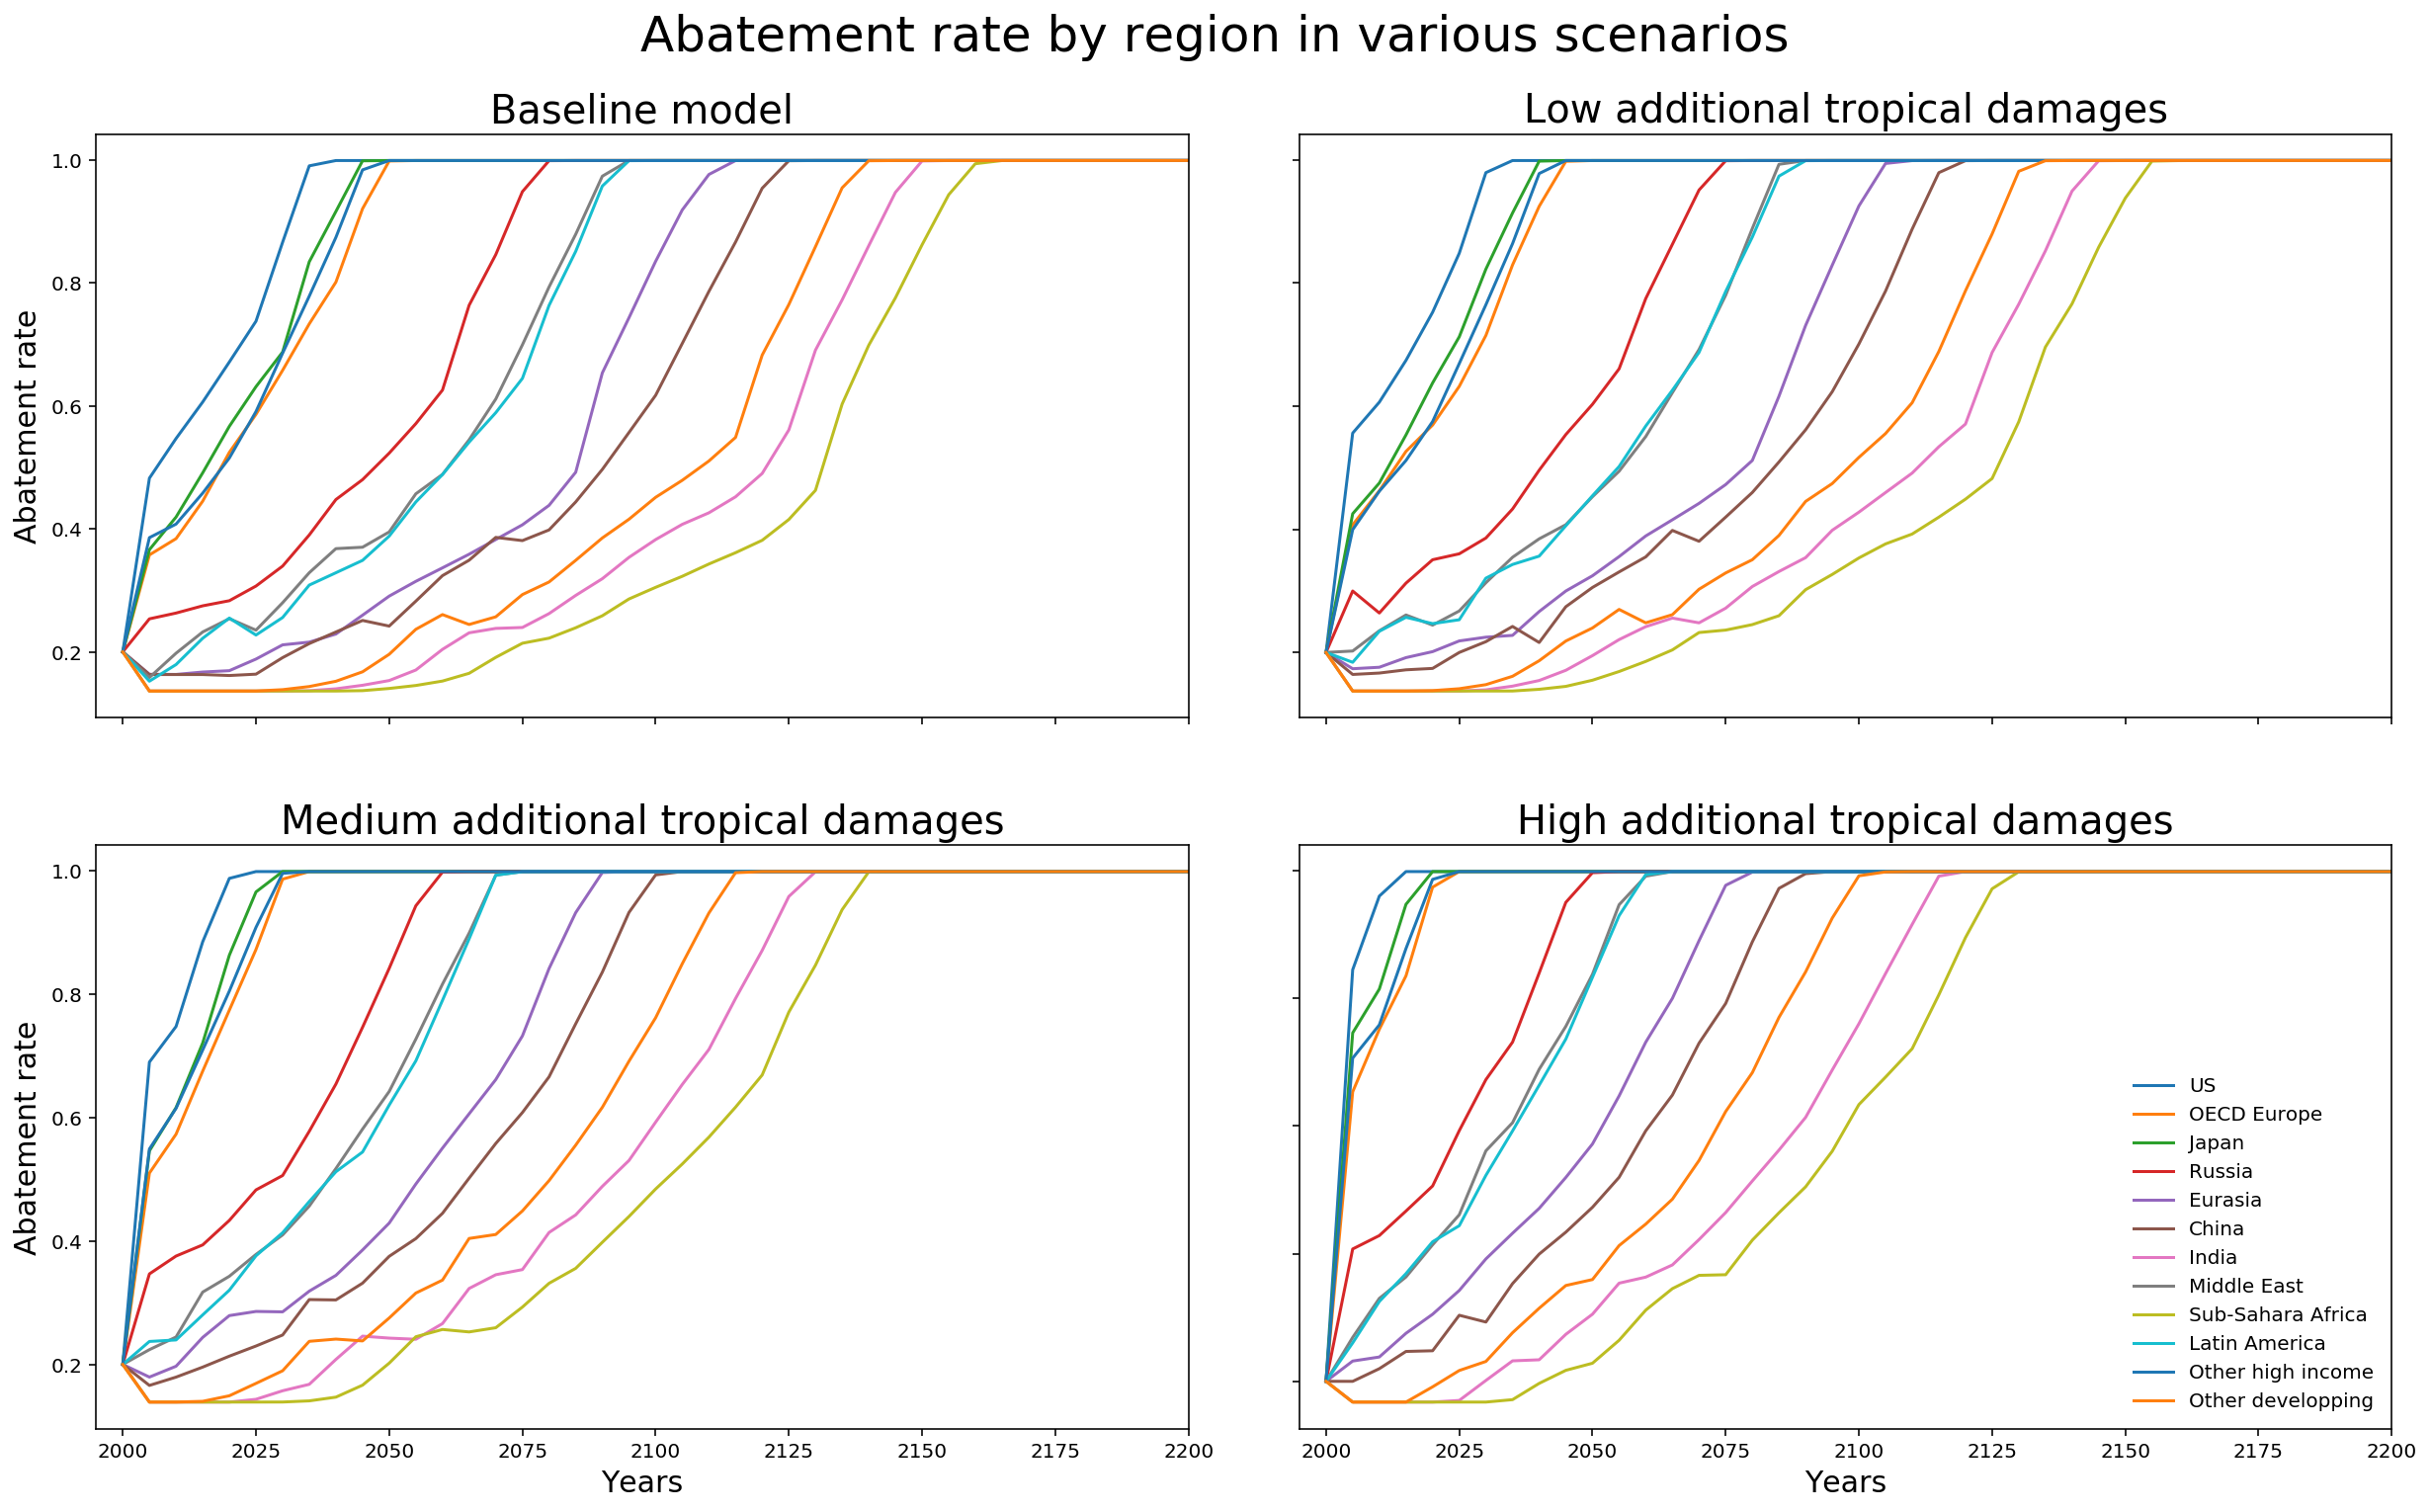

In [85]:
# Abatement rate for all regions, in four tropical scenarios

fig, axs = plt.subplots(2,2,figsize=(18, 11))
axs[0, 0].plot(df_MIU.loc[('tropical', 0)])
axs[0, 0].set_title('Baseline model', fontsize=20)
axs[0, 1].plot(df_MIU.loc[('tropical', 1)])
axs[0, 1].set_title('Low additional tropical damages', fontsize=20)
axs[1, 0].plot(df_MIU.loc[('tropical', 2)])
axs[1, 0].set_title('Medium additional tropical damages', fontsize=20)
axs[1, 1].plot(df_MIU.loc[('tropical', 3)])
axs[1, 1].set_title('High additional tropical damages', fontsize=20)
fig.suptitle('Abatement rate by region in various scenarios', fontsize=25, y = 1.0)

for ax in axs.flat:
    ax.set_xlabel('Years', fontsize=15)
    ax.set_xlim(1995,2200)
    ax.set_ylabel('Abatement rate', fontsize=15)
for ax in axs.flat:
    ax.label_outer()
    
plt.legend(COUNTRIES, frameon = False)
plt.tight_layout(4)
# plt.savefig('miu.png', dpi = 150)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1761: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1761: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1761: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1761: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1761: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1761: PerformanceWarning: indexing pas

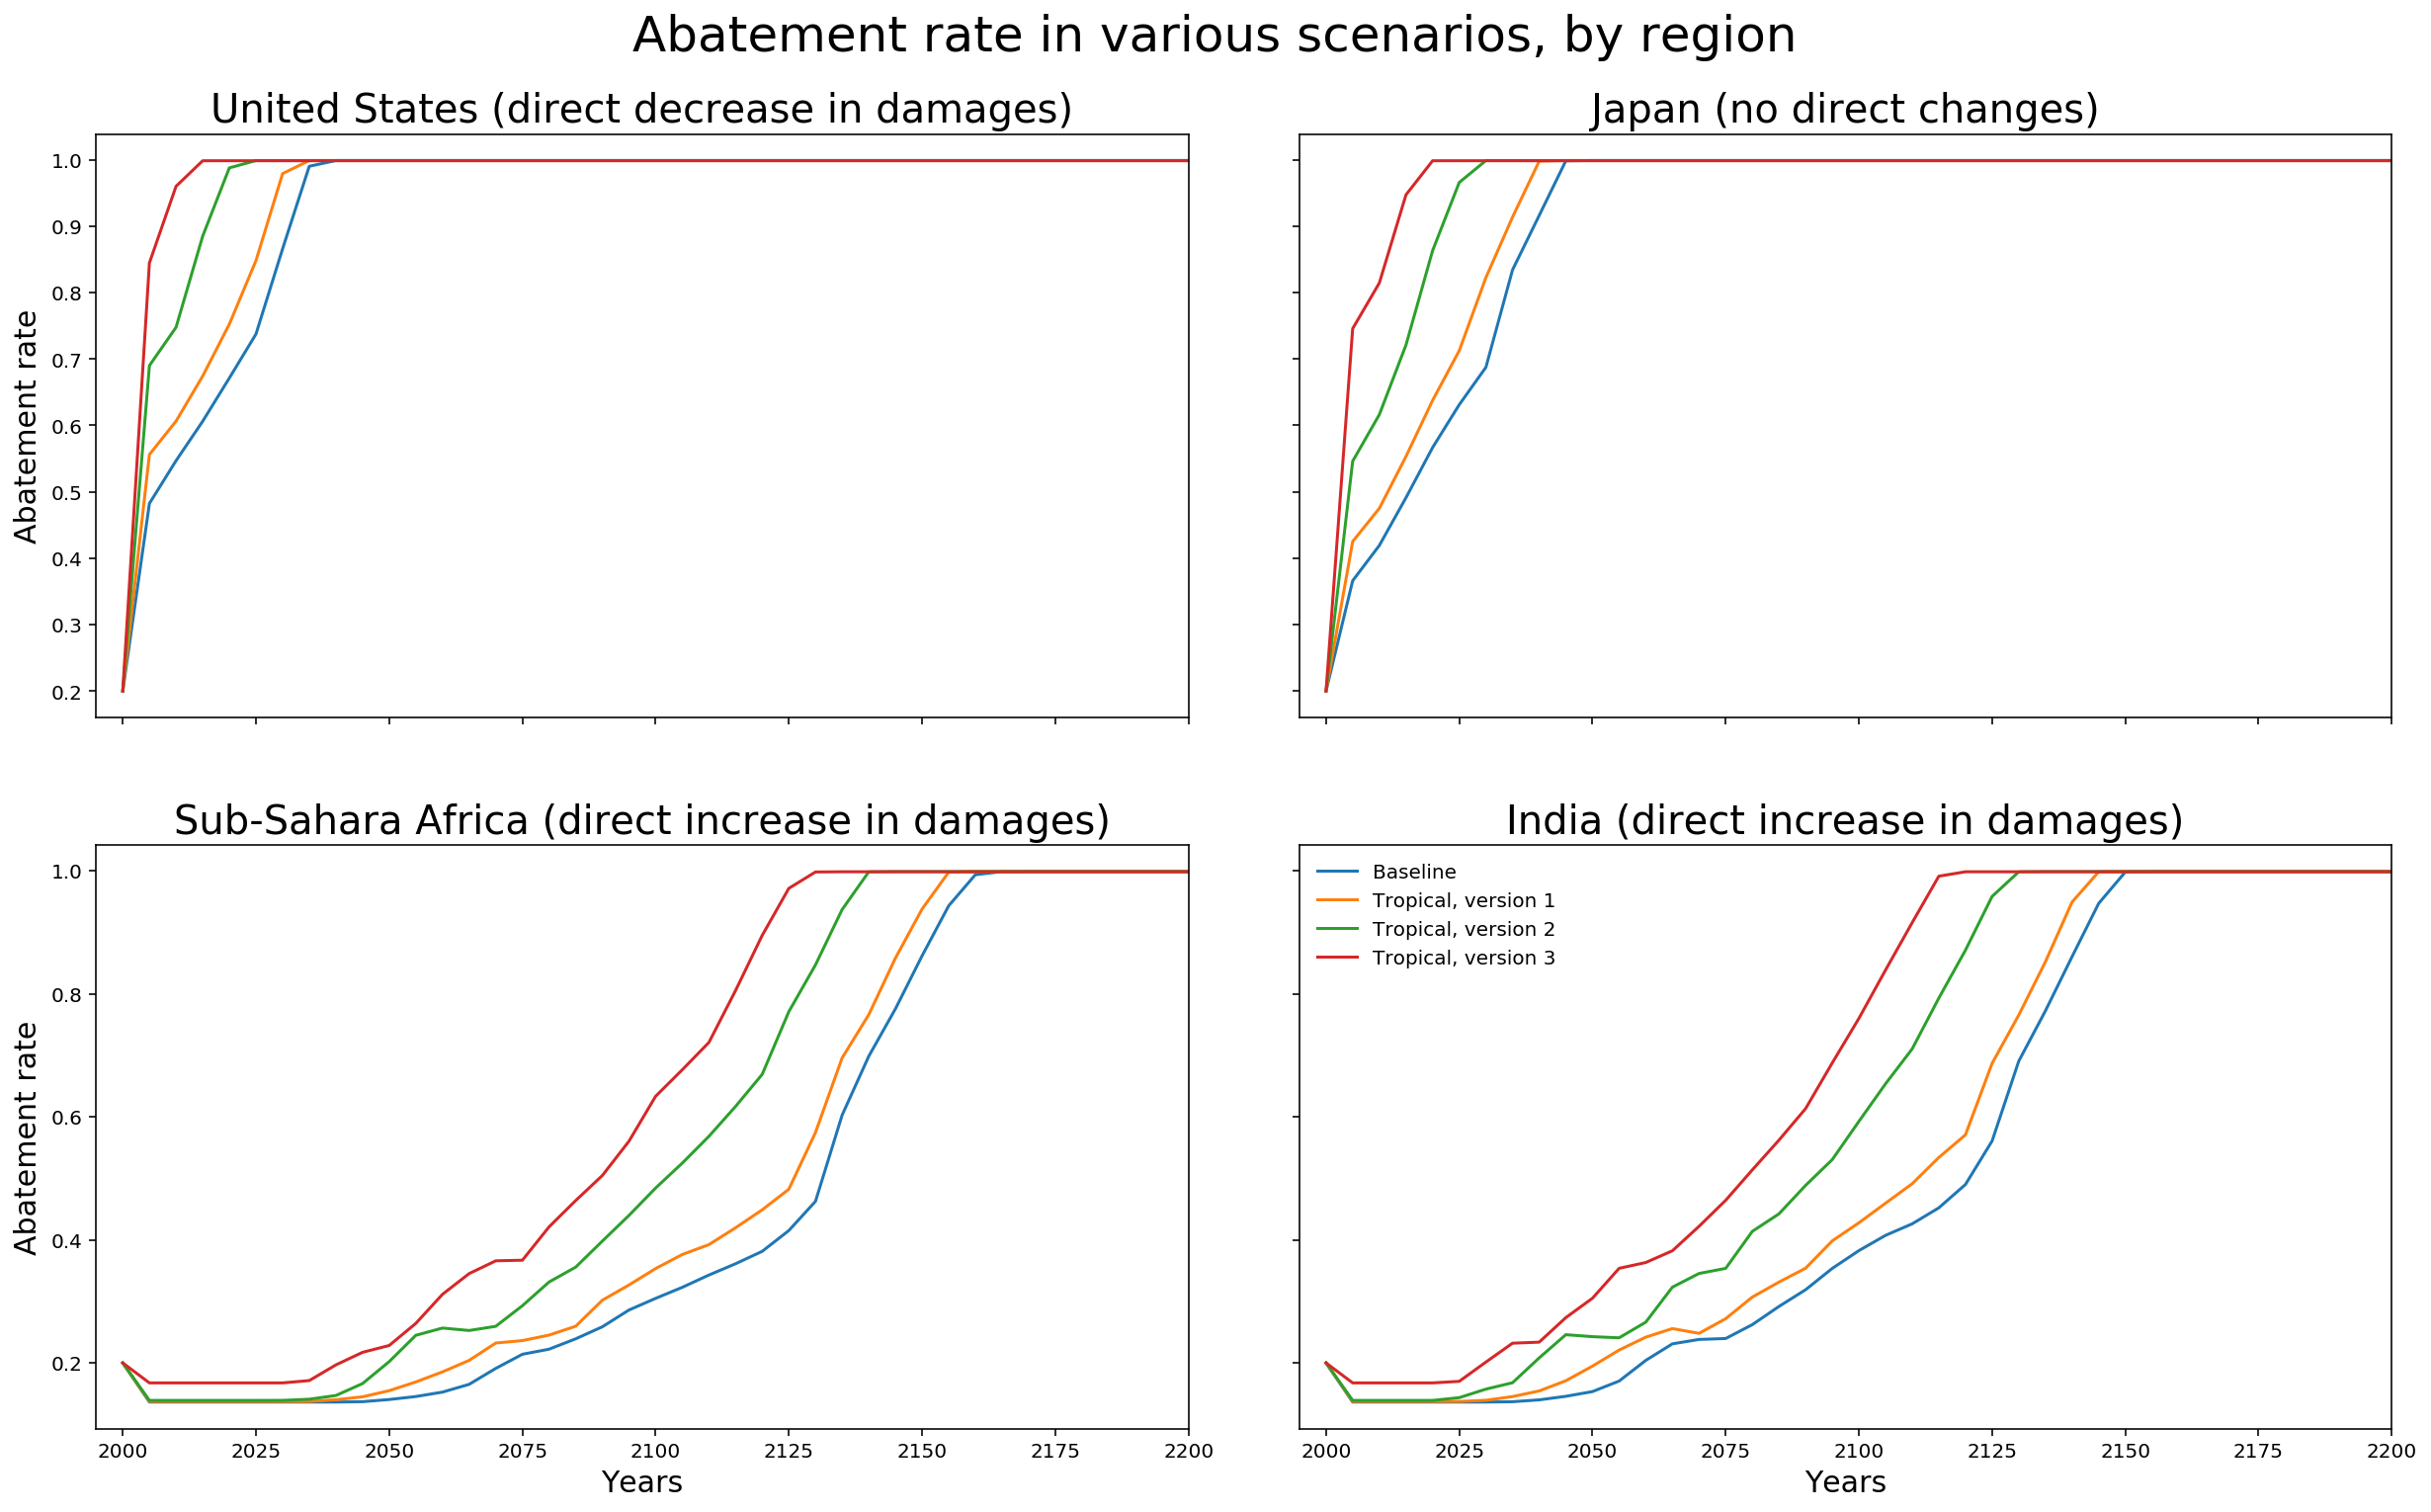

In [86]:
# Abatement rate by scenario, in four major regions

fig, axs = plt.subplots(2,2,figsize=(18, 11))
axs[0, 0].plot(df_MIU.loc[('tropical', 0),'US'])
axs[0, 0].plot(df_MIU.loc[('tropical', 1),'US'])
axs[0, 0].plot(df_MIU.loc[('tropical', 2),'US'])
axs[0, 0].plot(df_MIU.loc[('tropical', 3),'US'])
axs[0, 0].set_title('United States (direct decrease in damages)', fontsize=20)
axs[0, 1].plot(df_MIU.loc[('tropical', 0),'Japan'])
axs[0, 1].plot(df_MIU.loc[('tropical', 1),'Japan'])
axs[0, 1].plot(df_MIU.loc[('tropical', 2),'Japan'])
axs[0, 1].plot(df_MIU.loc[('tropical', 3),'Japan'])
axs[0, 1].set_title('Japan (no direct changes)', fontsize=20)
axs[1, 0].plot(df_MIU.loc[('tropical', 0),'Sub-Sahara Africa'])
axs[1, 0].plot(df_MIU.loc[('tropical', 1),'Sub-Sahara Africa'])
axs[1, 0].plot(df_MIU.loc[('tropical', 2),'Sub-Sahara Africa'])
axs[1, 0].plot(df_MIU.loc[('tropical', 3),'Sub-Sahara Africa'])
axs[1, 0].set_title('Sub-Sahara Africa (direct increase in damages)', fontsize=20)
axs[1, 1].plot(df_MIU.loc[('tropical', 0), 'India'])
axs[1, 1].plot(df_MIU.loc[('tropical', 1), 'India'])
axs[1, 1].plot(df_MIU.loc[('tropical', 2), 'India'])
axs[1, 1].plot(df_MIU.loc[('tropical', 3), 'India'])
axs[1, 1].set_title('India (direct increase in damages)', fontsize=20)
fig.suptitle('Abatement rate in various scenarios, by region', fontsize=25, y = 1.0)

for ax in axs.flat:
    ax.set_xlabel('Years', fontsize=15)
    ax.set_xlim(1995,2200)
    ax.set_ylabel('Abatement rate', fontsize=15)
for ax in axs.flat:
    ax.label_outer()
    
scenario = np.array(['Baseline', 'Tropical, version 1', 'Tropical, version 2', 'Tropical, version 3'])
    
plt.legend(scenario, frameon = False)
plt.tight_layout(4)
# plt.savefig('miu_region.png', dpi = 150)
plt.show()

#### New distribution of damages function coefficients

<function matplotlib.pyplot.show(*args, **kw)>

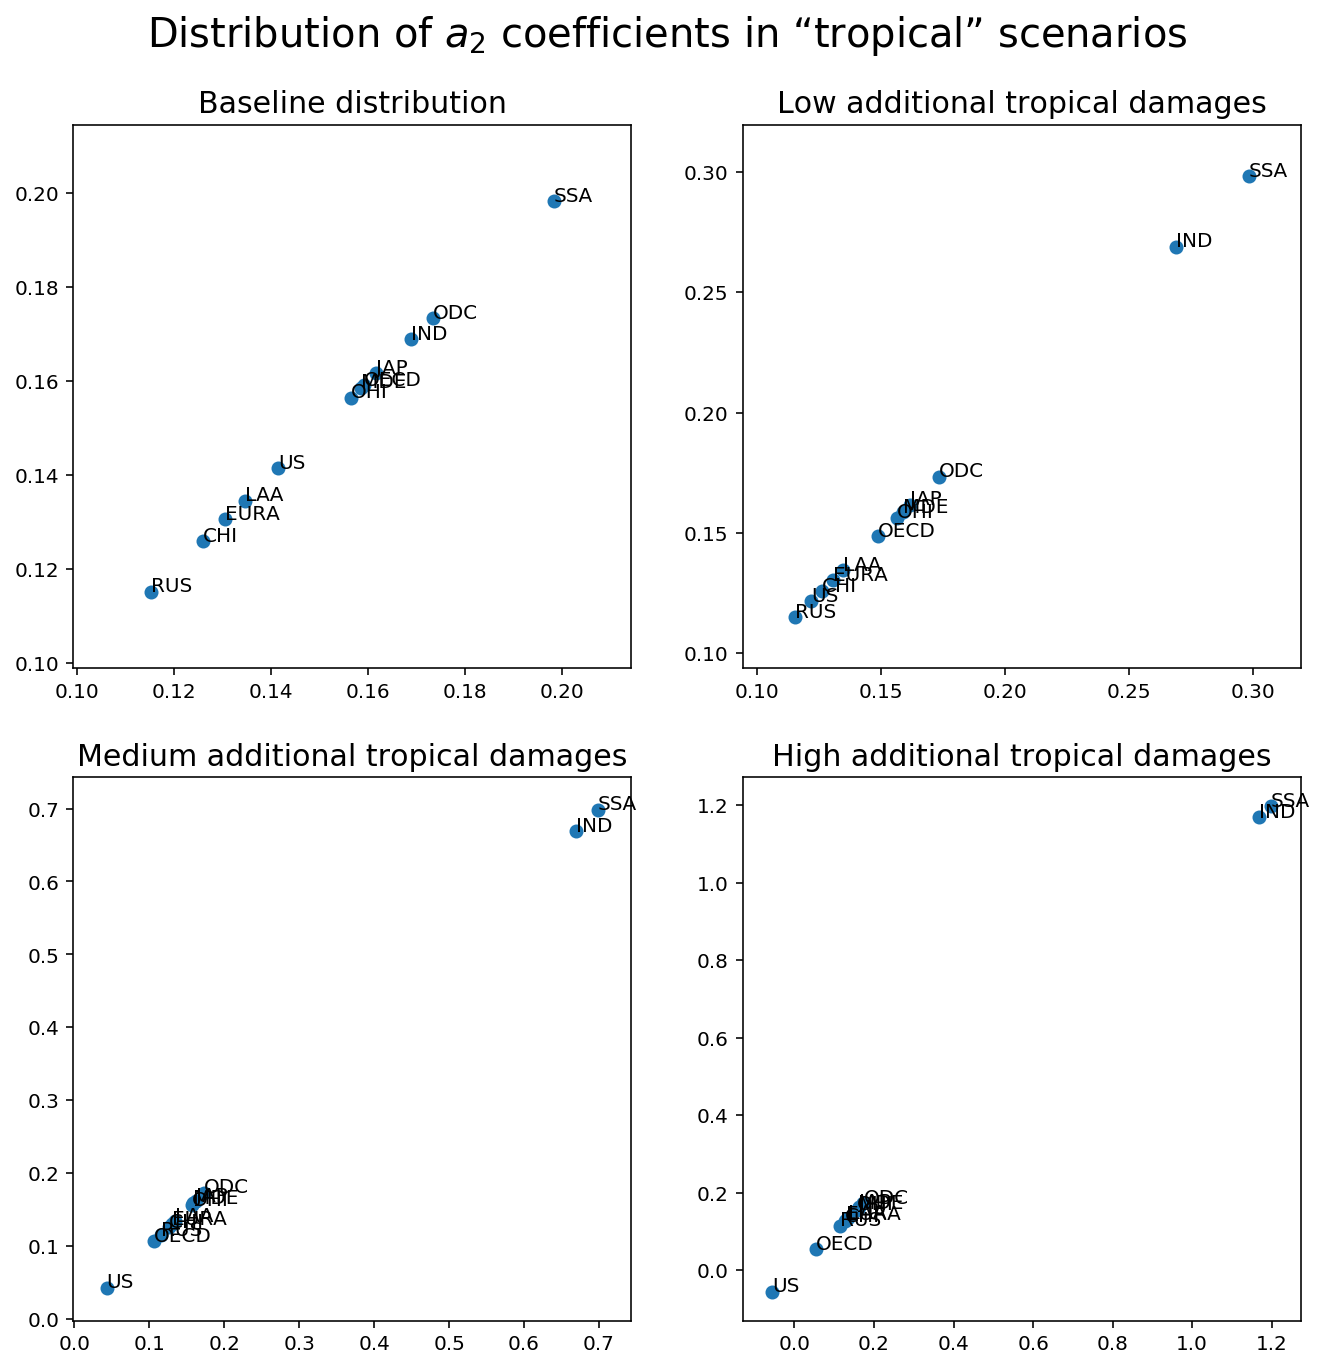

In [112]:
# Distribution of “tropical” coefficients

countries = np.array(['US', 'OECD', 'JAP', 'RUS', 'EURA', 'CHI', 'IND', 'MDE', 'SSA', 'LAA', 'OHI', 'ODC'])

fig, axs = plt.subplots(2,2,figsize=(11, 11))
axs[0,0].scatter(a20, a20)
axs[0,0].set_title('Baseline distribution', fontsize=15)
for i, txt in enumerate(countries):
    axs[0,0].annotate(txt, (a20[i], a20[i]))
axs[0,1].scatter(a21, a21)
axs[0,1].set_title('Low additional tropical damages', fontsize=15)
for i, txt in enumerate(countries):
    axs[0,1].annotate(txt, (a21[i], a21[i]))
axs[1,0].scatter(a22, a22)
axs[1,0].set_title('Medium additional tropical damages', fontsize=15)
for i, txt in enumerate(countries):
    axs[1,0].annotate(txt, (a22[i], a22[i]))
axs[1,1].scatter(a23, a23)
axs[1,1].set_title('High additional tropical damages', fontsize=15)
for i, txt in enumerate(countries):
    axs[1,1].annotate(txt, (a23[i], a23[i]))
    
fig.suptitle('Distribution of $a_2$ coefficients in “tropical” scenarios', fontsize=20, y = 0.95)
# plt.savefig('a2_tropical.png', dpi = 150)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

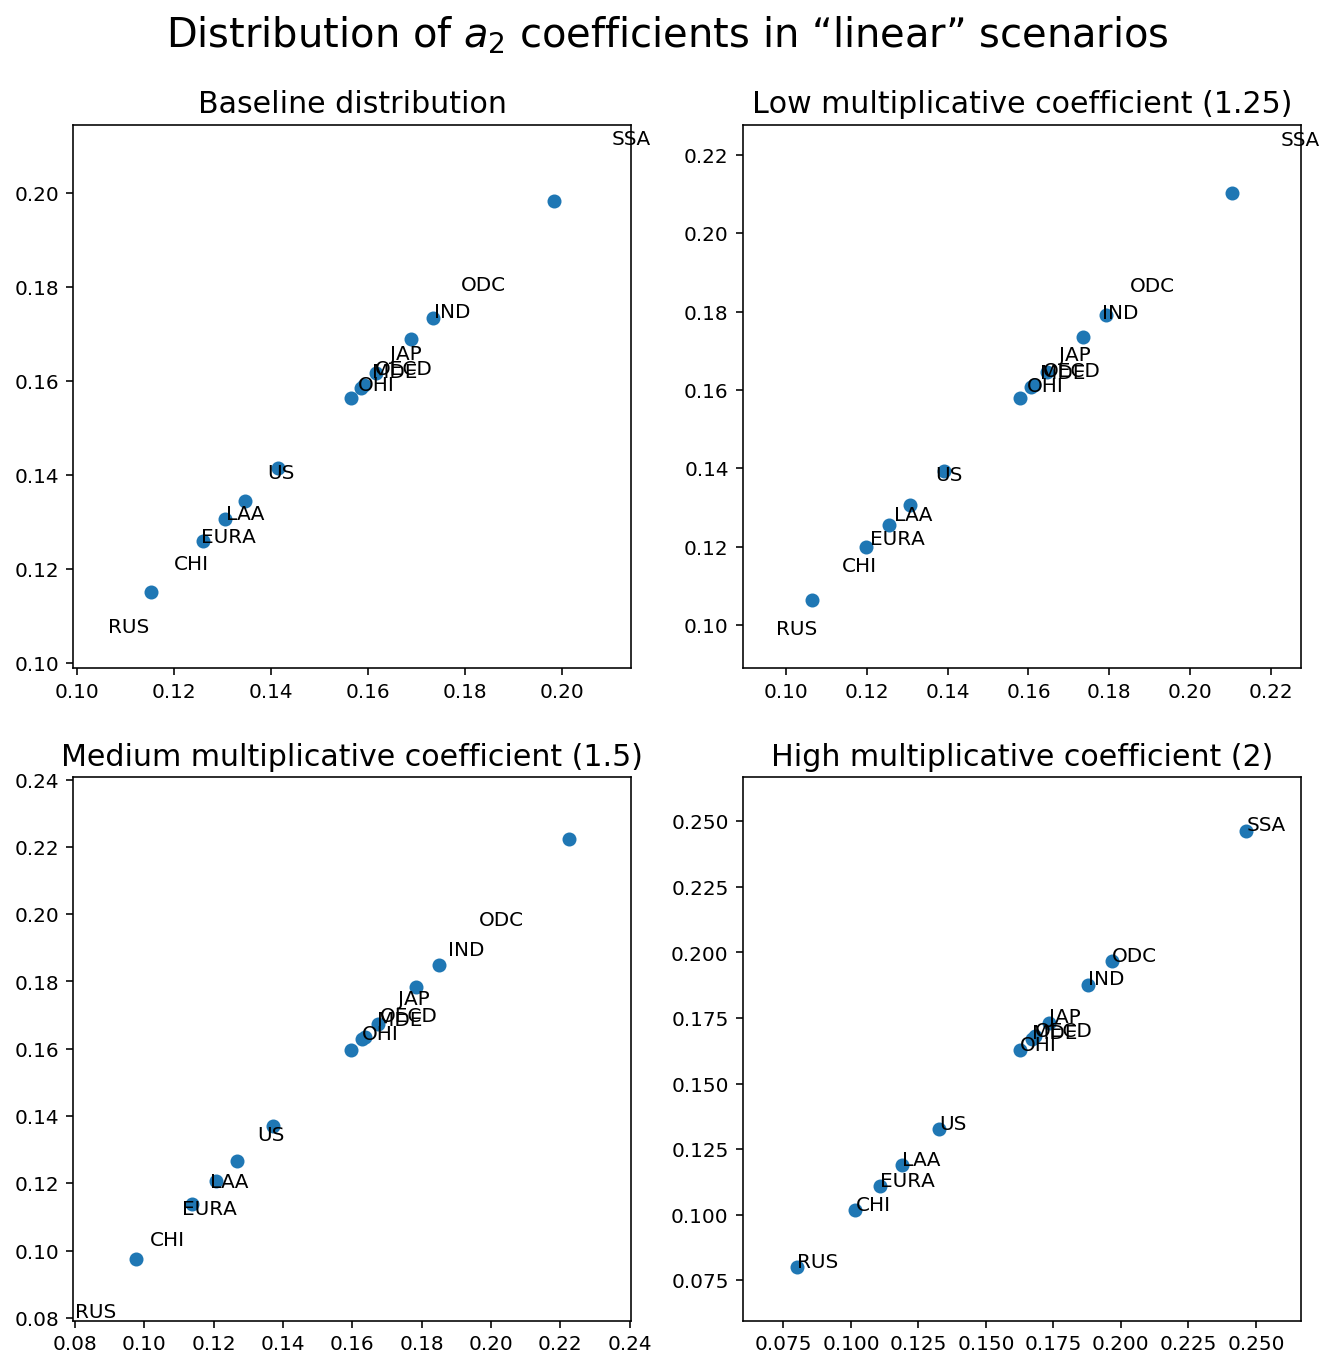

In [111]:
# Distribution of “linear” coefficients

a24 = a20.copy() * 1.25
a24 = a24 - (np.mean(a24*q0) - np.mean(a20*q0))/np.mean(q0)
a25 = a20.copy() * 1.5
a25 = a25 - (np.mean(a25*q0) - np.mean(a20*q0))/np.mean(q0)
a26 = a20.copy() * 2
a26 = a26 - (np.mean(a26*q0) - np.mean(a20*q0))/np.mean(q0)

fig, axs = plt.subplots(2,2,figsize=(11, 11))
axs[0,0].scatter(a20, a20)
axs[0,0].set_title('Baseline distribution', fontsize=15)
for i, txt in enumerate(countries):
    axs[0,0].annotate(txt, (a24[i], a24[i]))
axs[0,1].scatter(a24, a24)
axs[0,1].set_title('Low multiplicative coefficient (1.25)', fontsize=15)
for i, txt in enumerate(countries):
    axs[0,1].annotate(txt, (a25[i], a25[i]))
axs[1,0].scatter(a25, a25)
axs[1,0].set_title('Medium multiplicative coefficient (1.5)', fontsize=15)
for i, txt in enumerate(countries):
    axs[1,0].annotate(txt, (a26[i], a26[i]))
axs[1,1].scatter(a26, a26)
axs[1,1].set_title('High multiplicative coefficient (2)', fontsize=15)
for i, txt in enumerate(countries):
    axs[1,1].annotate(txt, (a26[i], a26[i]))
    
fig.suptitle('Distribution of $a_2$ coefficients in “linear” scenarios', fontsize=20, y = 0.95)
# plt.savefig('a2_linear.png', dpi = 150)
plt.show

#### Summary of results

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__

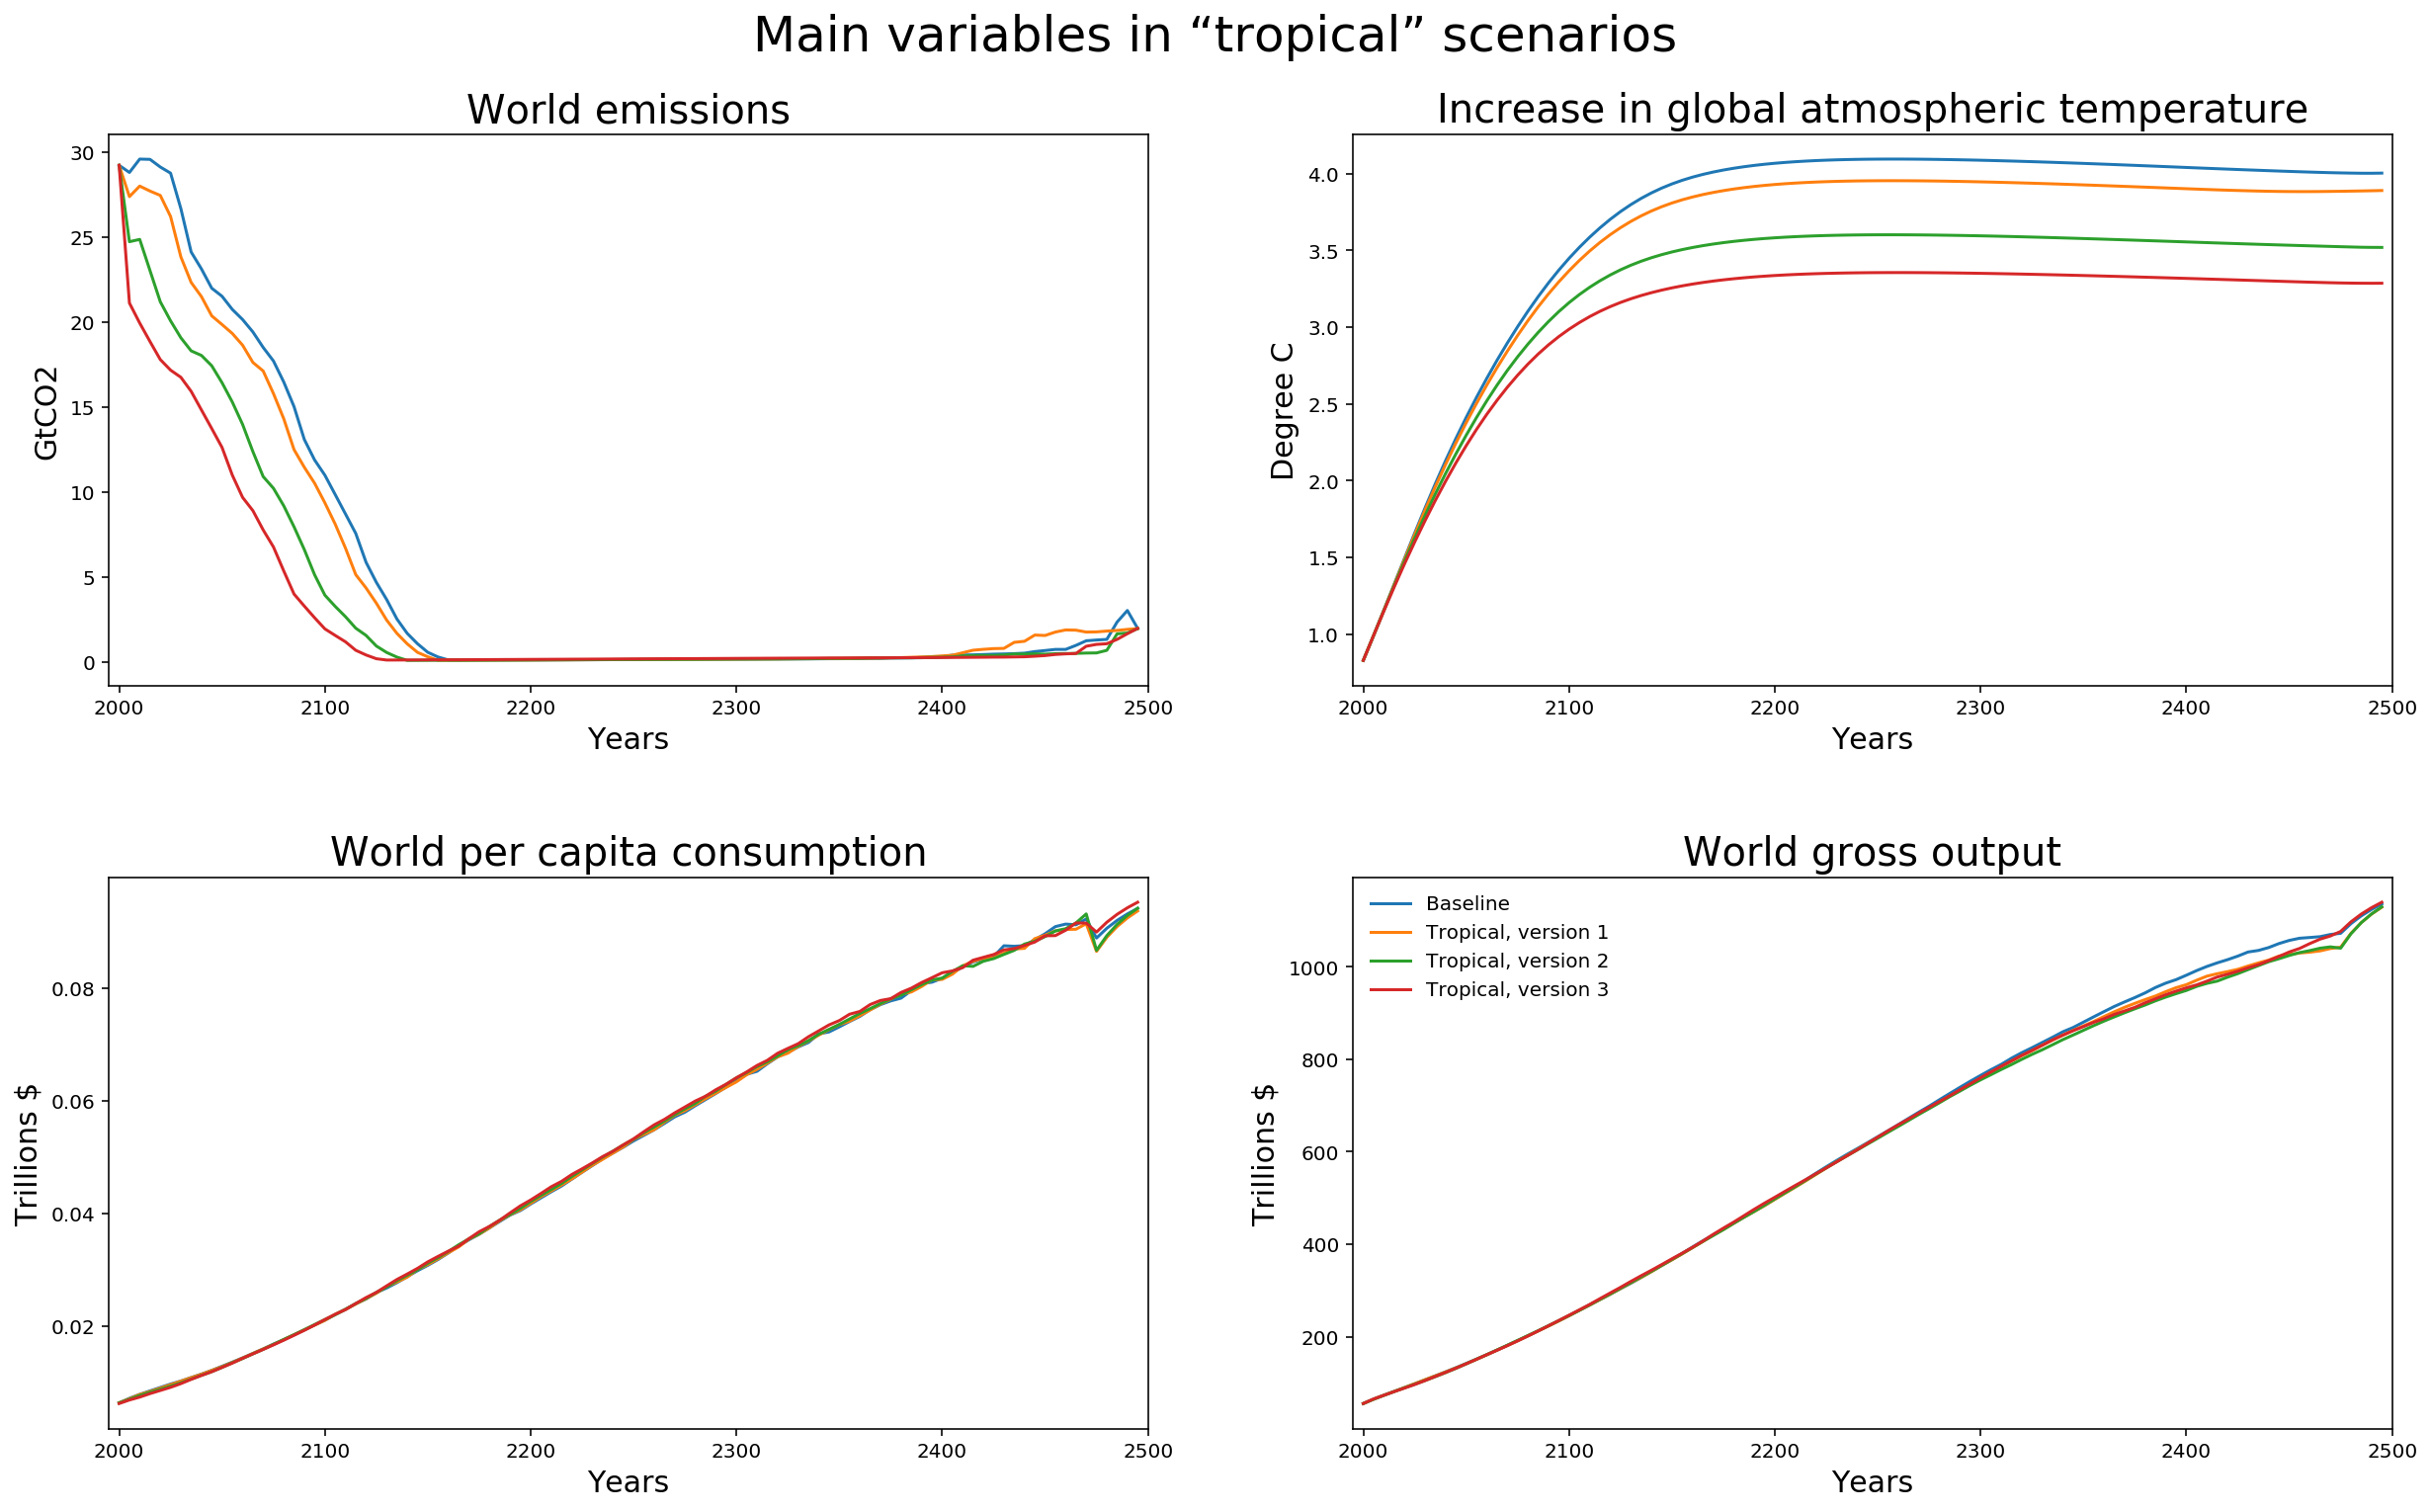

In [109]:
# Results overview for tropical scenarios

fig, axs = plt.subplots(2,2,figsize=(18, 11))
axs[0, 0].plot(df_WEIND.loc[('tropical', 0)])
axs[0, 0].plot(df_WEIND.loc[('tropical', 1)])
axs[0, 0].plot(df_WEIND.loc[('tropical', 2)])
axs[0, 0].plot(df_WEIND.loc[('tropical', 3)])
axs[0, 0].set_title('World emissions', fontsize=20)
axs[0, 0].set_ylabel('GtCO2', fontsize=15)
axs[0, 1].plot(df_TATM.loc[('tropical', 0)])
axs[0, 1].plot(df_TATM.loc[('tropical', 1)])
axs[0, 1].plot(df_TATM.loc[('tropical', 2)])
axs[0, 1].plot(df_TATM.loc[('tropical', 3)])
axs[0, 1].set_title('Increase in global atmospheric temperature', fontsize=20)
axs[0, 1].set_ylabel('Degree C', fontsize=15)
axs[1, 0].plot(df_WCPC.loc[('tropical', 0)])
axs[1, 0].plot(df_WCPC.loc[('tropical', 1)])
axs[1, 0].plot(df_WCPC.loc[('tropical', 2)])
axs[1, 0].plot(df_WCPC.loc[('tropical', 3)])
axs[1, 0].set_title('World per capita consumption', fontsize=20)
axs[1, 0].set_ylabel('Trillions $', fontsize=15)
axs[1, 1].plot(df_WYGROSS.loc[('tropical', 0)])
axs[1, 1].plot(df_WYGROSS.loc[('tropical', 1)])
axs[1, 1].plot(df_WYGROSS.loc[('tropical', 2)])
axs[1, 1].plot(df_WYGROSS.loc[('tropical', 3)])
axs[1, 1].set_title('World gross output', fontsize=20)
axs[1, 1].set_ylabel('Trillions $', fontsize=15)
fig.suptitle('Main variables in “tropical” scenarios', fontsize=25, y = 1.0)

for ax in axs.flat:
    ax.set_xlabel('Years', fontsize=15)
    ax.set_xlim(1995,2500)
    
scenario = np.array(['Baseline', 'Tropical, version 1', 'Tropical, version 2', 'Tropical, version 3'])
    
plt.legend(scenario, frameon = False)
plt.tight_layout(4)
# plt.savefig('tropic_final.png', dpi = 150)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__

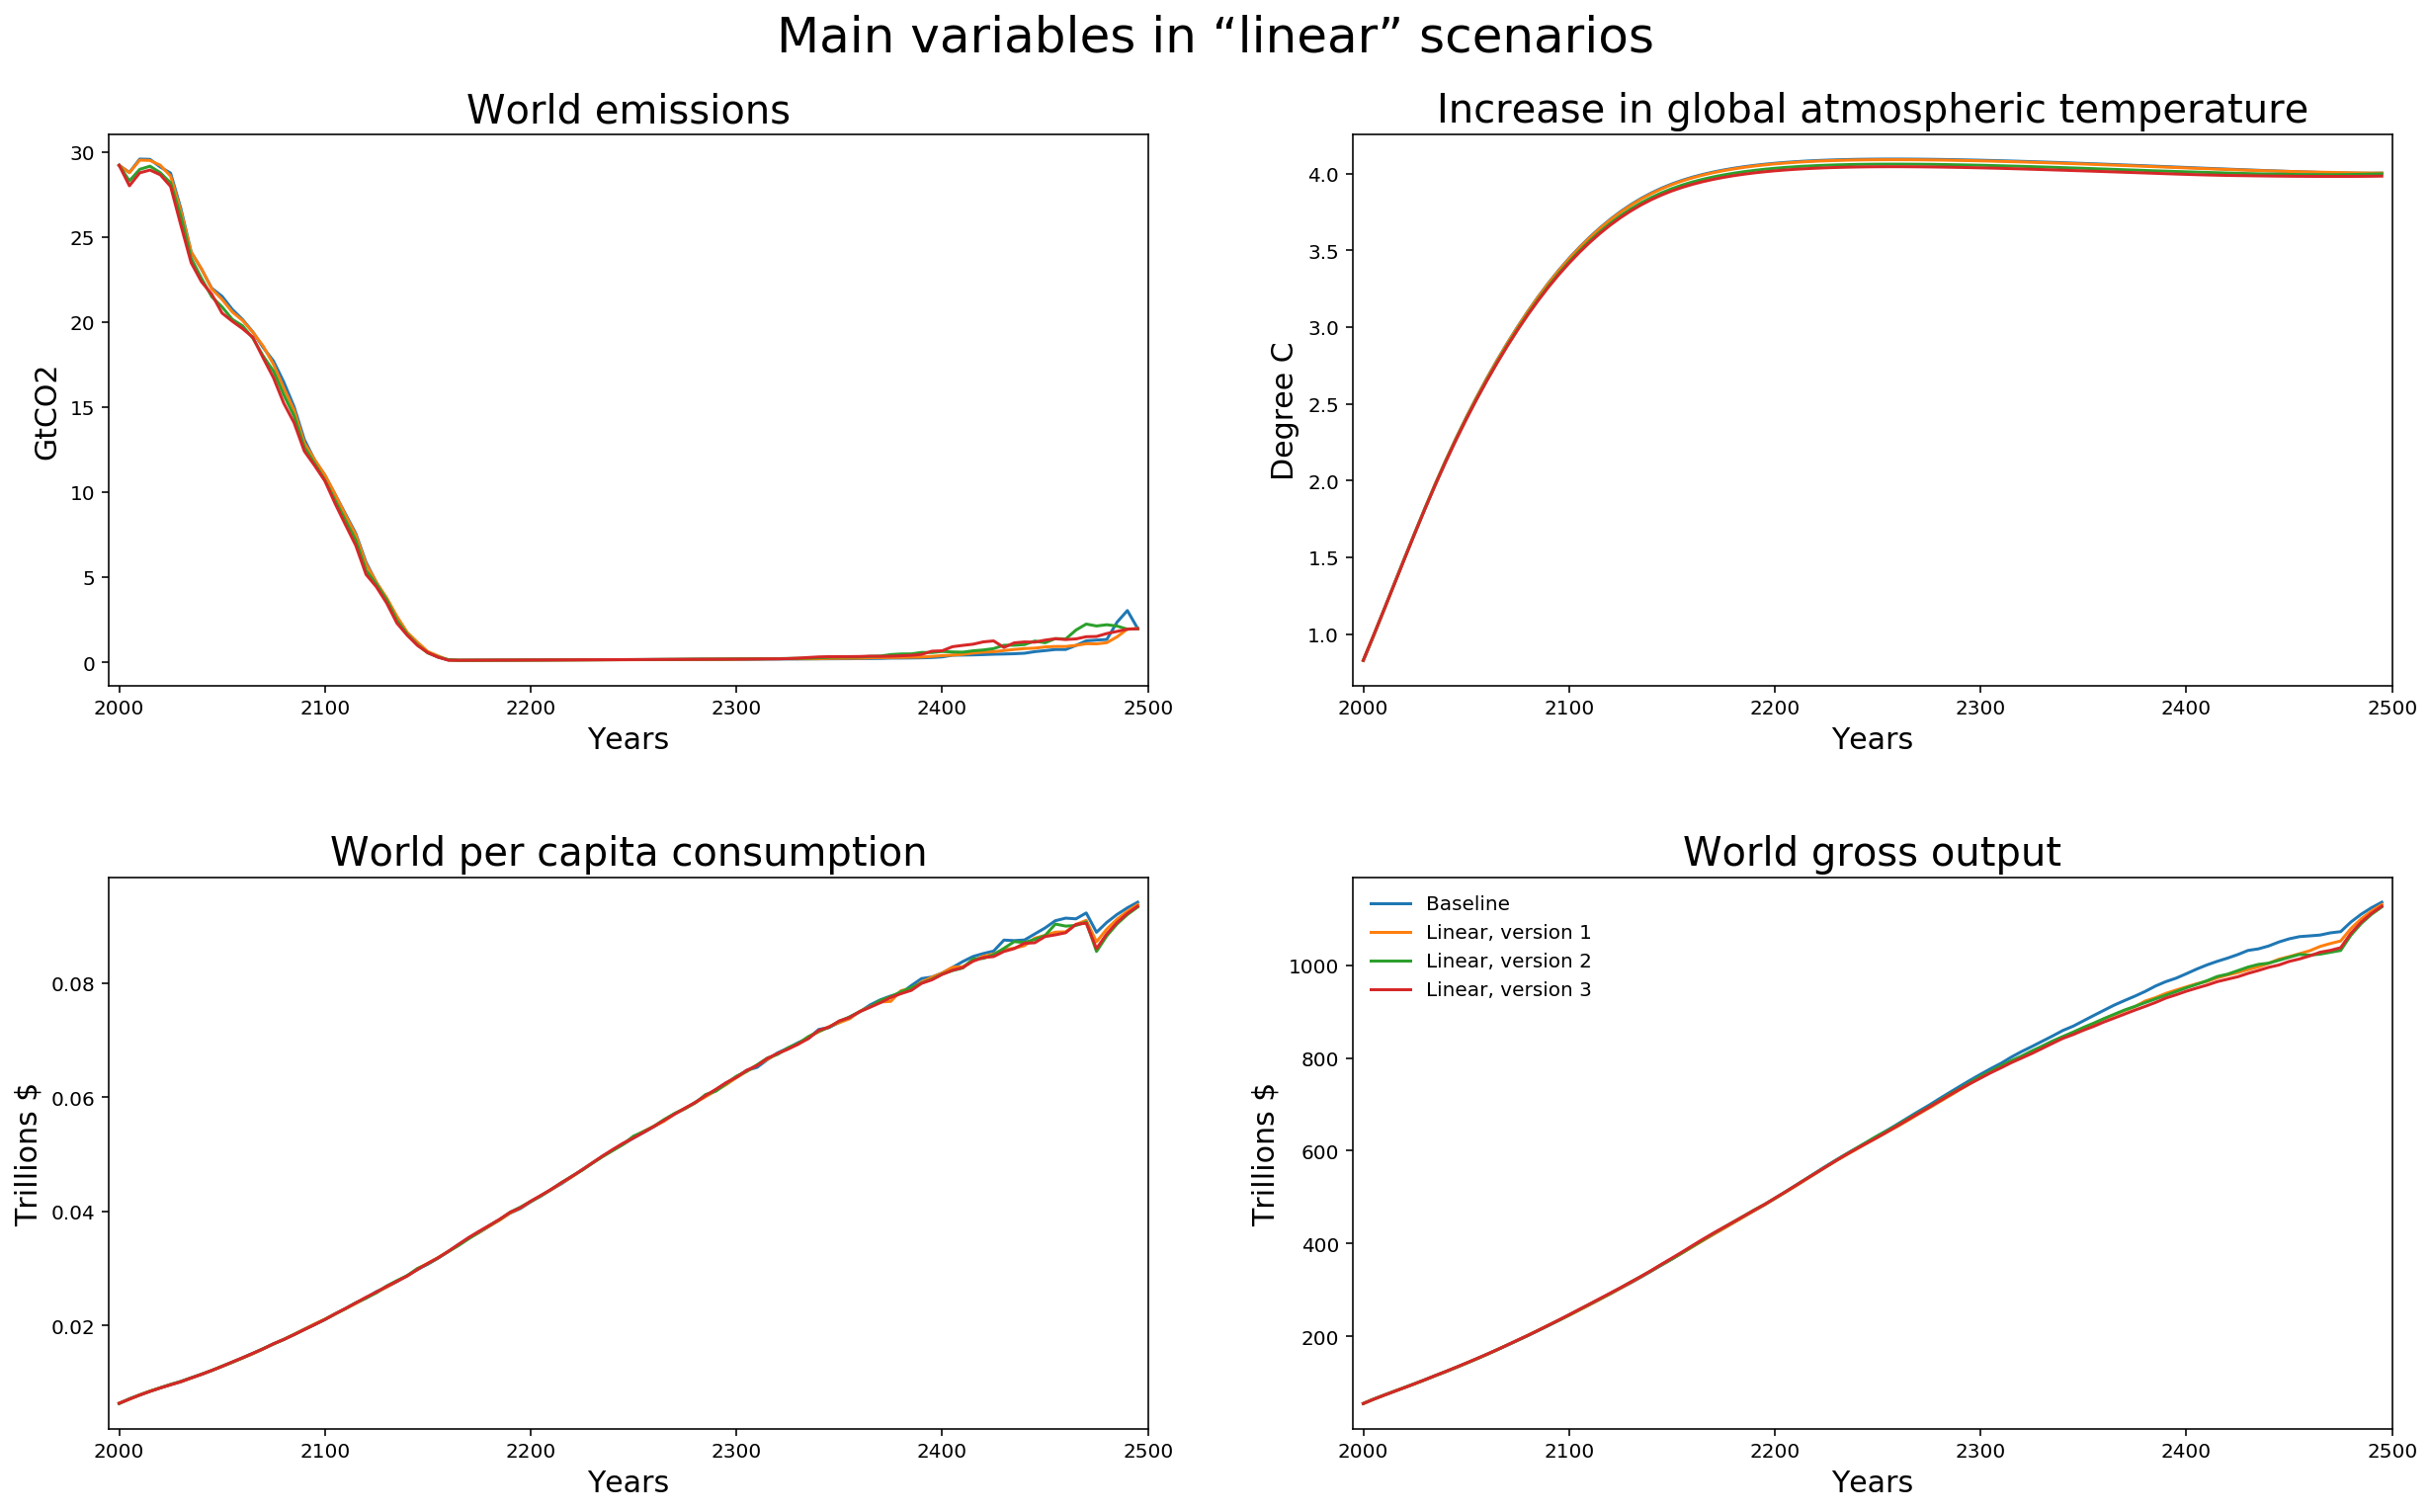

In [110]:
# Results overview for linear scenarios

fig, axs = plt.subplots(2,2,figsize=(18, 11))
axs[0, 0].plot(df_WEIND.loc[('tropical', 0)])
axs[0, 0].plot(df_WEIND.loc[('linear', 1)])
axs[0, 0].plot(df_WEIND.loc[('linear', 2)])
axs[0, 0].plot(df_WEIND.loc[('linear', 3)])
axs[0, 0].set_title('World emissions', fontsize=20)
axs[0, 0].set_ylabel('GtCO2', fontsize=15)
axs[0, 1].plot(df_TATM.loc[('tropical', 0)])
axs[0, 1].plot(df_TATM.loc[('linear', 1)])
axs[0, 1].plot(df_TATM.loc[('linear', 2)])
axs[0, 1].plot(df_TATM.loc[('linear', 3)])
axs[0, 1].set_title('Increase in global atmospheric temperature', fontsize=20)
axs[0, 1].set_ylabel('Degree C', fontsize=15)
axs[1, 0].plot(df_WCPC.loc[('tropical', 0)])
axs[1, 0].plot(df_WCPC.loc[('linear', 1)])
axs[1, 0].plot(df_WCPC.loc[('linear', 2)])
axs[1, 0].plot(df_WCPC.loc[('linear', 3)])
axs[1, 0].set_title('World per capita consumption', fontsize=20)
axs[1, 0].set_ylabel('Trillions $', fontsize=15)
axs[1, 1].plot(df_WYGROSS.loc[('tropical', 0)])
axs[1, 1].plot(df_WYGROSS.loc[('linear', 1)])
axs[1, 1].plot(df_WYGROSS.loc[('linear', 2)])
axs[1, 1].plot(df_WYGROSS.loc[('linear', 3)])
axs[1, 1].set_title('World gross output', fontsize=20)
axs[1, 1].set_ylabel('Trillions $', fontsize=15)
fig.suptitle('Main variables in “linear” scenarios', fontsize=25, y = 1.0)

for ax in axs.flat:
    ax.set_xlabel('Years', fontsize=15)
    ax.set_xlim(1995,2500)
    
scenario = np.array(['Baseline', 'Linear, version 1', 'Linear, version 2', 'Linear, version 3'])
    
plt.legend(scenario, frameon = False)
plt.tight_layout(4)
# plt.savefig('linear_final.png', dpi = 150)
plt.show()